In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
mrt_master_df = pd.read_csv('Data/Master Sets/TrainStationMaster.csv')

In [3]:
mrt_master_df.head()

,Unnamed: 0,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,0,2024-03,WEEKDAY,11,TRAIN,NS7,21943,15130
1,1,2024-03,WEEKENDS/HOLIDAY,11,TRAIN,NS7,13062,14512
2,2,2024-03,WEEKDAY,16,TRAIN,SW4,2124,3233
3,3,2024-03,WEEKENDS/HOLIDAY,16,TRAIN,SW4,1532,1736
4,4,2024-03,WEEKENDS/HOLIDAY,10,TRAIN,CC5,1886,2659


In [4]:
station_network_list = mrt_master_df['PT_CODE'].unique()
station_network_list.sort()
station_network_list
station_interchanges = [i for i in station_network_list if '/' in i]
station_network_lines = pd.array([re.sub('[0-9]', '', i) for i in station_network_list]).unique()
station_network_lines = [i for i in station_network_lines if '/' not in i]

In [5]:
station_network_list

array(['BP10', 'BP11', 'BP12', 'BP13', 'BP2', 'BP3', 'BP4', 'BP5',
       'BP6/DT1', 'BP7', 'BP8', 'BP9', 'CC10/DT26', 'CC11', 'CC12',
       'CC14', 'CC16', 'CC17/TE9', 'CC19/DT9', 'CC2', 'CC20', 'CC21',
       'CC23', 'CC24', 'CC25', 'CC26', 'CC27', 'CC28', 'CC3', 'CC4/DT15',
       'CC5', 'CC6', 'CC7', 'CC8', 'CE1/DT16', 'CG1/DT35', 'CG2', 'DT10',
       'DT10/TE11', 'DT13', 'DT17', 'DT18', 'DT2', 'DT20', 'DT21', 'DT22',
       'DT23', 'DT24', 'DT25', 'DT27', 'DT28', 'DT29', 'DT3', 'DT30',
       'DT31', 'DT33', 'DT34', 'DT5', 'DT6', 'DT7', 'DT8', 'EW1', 'EW10',
       'EW11', 'EW12/DT14', 'EW14/NS26', 'EW15', 'EW16/NE3/TE17', 'EW17',
       'EW18', 'EW19', 'EW2/DT32', 'EW20', 'EW21/CC22', 'EW22', 'EW23',
       'EW24/NS1', 'EW25', 'EW26', 'EW27', 'EW28', 'EW29', 'EW3', 'EW30',
       'EW31', 'EW32', 'EW33', 'EW4', 'EW5', 'EW6', 'EW7', 'EW8/CC9',
       'EW9', 'NE1/CC29', 'NE10', 'NE11', 'NE12/CC13', 'NE13', 'NE14',
       'NE15', 'NE16/STC', 'NE17/PTC', 'NE4/DT19', 'NE5', 'NE7/DT12

In [6]:
def generate_line_net(line: str, start: int = 1, end: int = 99):
    if line not in station_network_lines:
        raise ValueError('Not a valid MRT Line')
    count = start
    adj = {}
    for station in station_network_list:
        if line in station:
            if f"{line}{count}" in station_network_list:
                adj[f"{line}{count}"] = {}
                adj[f"{line}{count}"][f"{line}{count}"] = 0
                if f"{line}{count-1}" in station_network_list:
                    adj[f"{line}{count}"][f"{line}{count-1}"] = 1
                    if f"{line}{count-1}" not in adj:
                        adj[f"{line}{count-1}"] = {}
                    adj[f"{line}{count-1}"][f"{line}{count}"] = 1
                if f"{line}{count+1}" in station_network_list:
                    adj[f"{line}{count}"][f"{line}{count+1}"] = 1
                    if f"{line}{count+1}" not in adj:
                        adj[f"{line}{count+1}"] = {}
                    adj[f"{line}{count+1}"][f"{line}{count}"] = 1
            count += 1
            if count > end:
                break
    
    return adj

def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    all_rows = range(0, adjacency_matrix.shape[0])
    for n in all_rows:
        gr.add_node(n)
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=900, labels=mylabels, with_labels=True)
    plt.show()

In [7]:
adj_TE = generate_line_net('TE')

In [8]:
# MANUAL ADJUSTMENT FOR INTERCHANGE STATIONS
for station in station_interchanges:
    if 'TE' in station:
        print(station)
        adj_TE[station] = {}

# ONLY 6 Stations for TE Line
adj_TE['CC17/TE9']['TE8'] = 1
adj_TE['TE8']['CC17/TE9'] = 1

adj_TE['CC17/TE9']['DT10/TE11'] = 1
adj_TE['DT10/TE11']['CC17/TE9'] = 1

adj_TE['DT10/TE11']['TE12'] = 1
adj_TE['TE12']['DT10/TE11'] = 1

adj_TE['EW16/NE3/TE17']['TE16'] = 1
adj_TE['TE16']['EW16/NE3/TE17'] = 1
adj_TE['EW16/NE3/TE17']['TE18'] = 1
adj_TE['TE18']['EW16/NE3/TE17'] = 1

adj_TE['NS27/CE2/TE20']['TE19'] = 1
adj_TE['TE19']['NS27/CE2/TE20'] = 1
adj_TE['NS27/CE2/TE20']['TE22'] = 1
adj_TE['TE22']['NS27/CE2/TE20'] = 1

adj_TE['NS27/CE2/TE20']['TE19'] = 1
adj_TE['TE19']['NS27/CE2/TE20'] = 1
adj_TE['NS27/CE2/TE20']['TE22'] = 1
adj_TE['TE22']['NS27/CE2/TE20'] = 1

adj_TE['NS9/TE2']['TE1'] = 1
adj_TE['TE1']['NS9/TE2'] = 1
adj_TE['NS9/TE2']['TE3'] = 1
adj_TE['TE3']['NS9/TE2'] = 1

adj_TE['TE14/NS22']['TE13'] = 1
adj_TE['TE13']['TE14/NS22'] = 1
adj_TE['TE14/NS22']['TE15'] = 1
adj_TE['TE15']['TE14/NS22'] = 1

CC17/TE9
DT10/TE11
EW16/NE3/TE17
NS27/CE2/TE20
NS9/TE2
TE14/NS22


In [9]:
# Adding adjacencies for NS Line connecting to Woodlands
adj_NS = generate_line_net('NS', 7, 11)

In [10]:
adj_NS['NS9/TE2'] = {}
adj_NS['NS9/TE2']['NS8'] = 1
adj_NS['NS8']['NS9/TE2'] = 1
adj_NS['NS9/TE2']['NS10'] = 1
adj_NS['NS10']['NS9/TE2'] = 1

adj_NS['NS5'] = {}
adj_NS['NS5']['NS7'] = 1
adj_NS['NS7']['NS5'] = 1

In [11]:
adj_NS

{'NS7': {'NS7': 0, 'NS8': 1, 'NS5': 1},
 'NS8': {'NS8': 0, 'NS7': 1, 'NS9/TE2': 1},
 'NS10': {'NS10': 0, 'NS11': 1, 'NS9/TE2': 1},
 'NS11': {'NS11': 0, 'NS10': 1, 'NS12': 1},
 'NS12': {'NS11': 1},
 'NS9/TE2': {'NS8': 1, 'NS10': 1},
 'NS5': {'NS7': 1}}

In [12]:
adj_CC = generate_line_net('CC', 14, 21)

In [13]:
adj_CC['NS17/CC15'] = {}
adj_CC['NS17/CC15']['CC14'] = 1
adj_CC['CC14']['NS17/CC15'] = 1
adj_CC['NS17/CC15']['CC16'] = 1
adj_CC['CC16']['NS17/CC15'] = 1


adj_CC['CC17/TE9'] = {}
adj_CC['CC17/TE9']['CC16'] = 1
adj_CC['CC16']['CC17/TE9'] = 1

adj_CC['CC19/DT9'] = {}
adj_CC['CC17/TE9']['CC19/DT9'] = 1
adj_CC['CC19/DT9']['CC17/TE9'] = 1
adj_CC['CC20']['CC19/DT9'] = 1
adj_CC['CC19/DT9']['CC20'] = 1


In [14]:
adj_CC

{'CC14': {'CC14': 0, 'NS17/CC15': 1},
 'CC16': {'CC16': 0, 'NS17/CC15': 1, 'CC17/TE9': 1},
 'CC20': {'CC20': 0, 'CC21': 1, 'CC19/DT9': 1},
 'CC21': {'CC21': 0, 'CC20': 1},
 'NS17/CC15': {'CC14': 1, 'CC16': 1},
 'CC17/TE9': {'CC16': 1, 'CC19/DT9': 1},
 'CC19/DT9': {'CC17/TE9': 1, 'CC20': 1}}

In [15]:
adj = {}
adj.update(adj_TE)
adj.update(adj_NS)
adj.update(adj_CC)
adj

{'TE1': {'TE1': 0, 'NS9/TE2': 1},
 'TE3': {'TE3': 0, 'TE4': 1, 'NS9/TE2': 1},
 'TE4': {'TE4': 0, 'TE3': 1, 'TE5': 1},
 'TE5': {'TE5': 0, 'TE4': 1, 'TE6': 1},
 'TE6': {'TE6': 0, 'TE5': 1, 'TE7': 1},
 'TE7': {'TE7': 0, 'TE6': 1, 'TE8': 1},
 'TE8': {'TE8': 0, 'TE7': 1, 'CC17/TE9': 1},
 'TE11': {'TE11': 0, 'TE12': 1},
 'TE12': {'TE12': 0, 'TE11': 1, 'TE13': 1, 'DT10/TE11': 1},
 'TE13': {'TE13': 0, 'TE12': 1, 'TE14/NS22': 1},
 'TE15': {'TE15': 0, 'TE16': 1, 'TE14/NS22': 1},
 'TE16': {'TE16': 0, 'TE15': 1, 'EW16/NE3/TE17': 1},
 'TE18': {'TE18': 0, 'TE19': 1, 'EW16/NE3/TE17': 1},
 'TE19': {'TE19': 0, 'TE18': 1, 'NS27/CE2/TE20': 1},
 'TE22': {'TE22': 0, 'TE23': 1, 'NS27/CE2/TE20': 1},
 'TE23': {'TE23': 0, 'TE22': 1, 'TE24': 1},
 'TE24': {'TE24': 0, 'TE23': 1, 'TE25': 1},
 'TE25': {'TE25': 0, 'TE24': 1, 'TE26': 1},
 'TE26': {'TE26': 0, 'TE25': 1, 'TE27': 1},
 'TE27': {'TE27': 0, 'TE26': 1, 'TE28': 1},
 'TE28': {'TE28': 0, 'TE27': 1, 'TE29': 1},
 'TE29': {'TE28': 1},
 'CC17/TE9': {'CC16': 1, 'CC

In [16]:
# Connecting Botanics and Stevens
adj['CC19/DT9']['DT10/TE11'] = 1
adj['DT10/TE11']['CC19/DT9'] = 1

In [17]:
adj_matrix = pd.DataFrame(adj).fillna(0)
adj_matrix = adj_matrix.sort_index(axis=1).copy()
adj_matrix = adj_matrix.sort_index().copy()
adj_matrix

,CC14,CC16,CC17/TE9,CC19/DT9,CC20,CC21,DT10/TE11,EW16/NE3/TE17,NS10,NS11,...,TE26,TE27,TE28,TE29,TE3,TE4,TE5,TE6,TE7,TE8
CC14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CC16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CC17/TE9,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
CC19/DT9,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CC20,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CC21,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DT10/TE11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EW16/NE3/TE17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NS10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NS11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
adj_matrix.to_csv('Data\Master Sets\TE_Line_Adjacency_Matrix_Extended.csv')

In [19]:
G = nx.from_pandas_adjacency(adj_matrix)

In [20]:
print(G)
G.nodes

Graph with 40 nodes and 40 edges


NodeView(('CC14', 'CC16', 'CC17/TE9', 'CC19/DT9', 'CC20', 'CC21', 'DT10/TE11', 'EW16/NE3/TE17', 'NS10', 'NS11', 'NS12', 'NS17/CC15', 'NS27/CE2/TE20', 'NS5', 'NS7', 'NS8', 'NS9/TE2', 'TE1', 'TE11', 'TE12', 'TE13', 'TE14/NS22', 'TE15', 'TE16', 'TE18', 'TE19', 'TE22', 'TE23', 'TE24', 'TE25', 'TE26', 'TE27', 'TE28', 'TE29', 'TE3', 'TE4', 'TE5', 'TE6', 'TE7', 'TE8'))

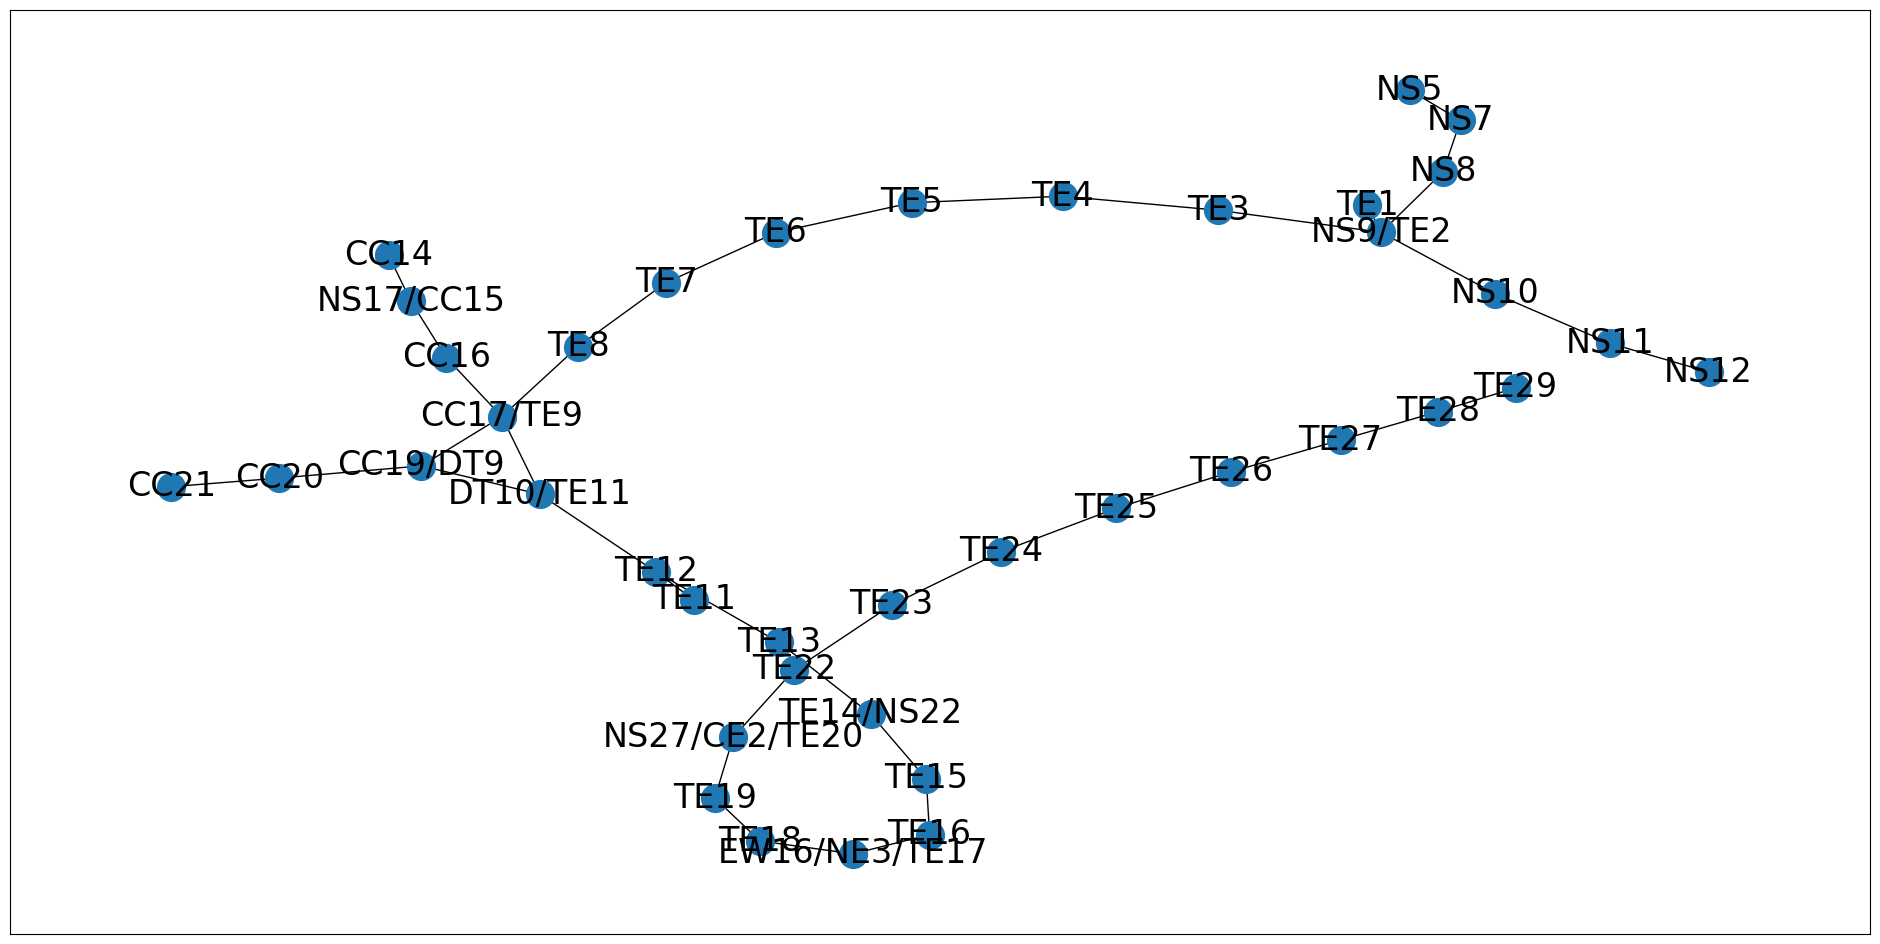

In [21]:
f = plt.figure(figsize=(24, 12))
nx.draw_networkx(G, node_size = 400, font_size = 24)
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html

In [22]:
adj_DT = generate_line_net('DT')